Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Exercise03

## Problem

In the last exercise, you used tabular analyses to examine how eviction impacts tenants in Montgomery and Prince George's Counties. In this exercise, you will use more precise, address-level data to analyze evictions across the entire state through a spatial lens.

**You get to write your own research question, but with a few parameters:**
- It should be addressable with the provided eviction data
- It should require that you relate the eviction data to at least one other dataset, which you provide
- It should involve at least one form of spatial analysis (e.g., proximity, overlay, or measurement of another spatial relationship)

**Please write a short abstract (200-300 words) at the top of your exercise notebook that concisely summarizes your research question, how you addressed it, and the results of your analysis. Then provide reproducible code in cells below.**

### Bonus

Only a portion of the eviction records I'm providing for this exercise have addresses that can be geocoded (converting address strings to geographic coordinates) with a high degree of accuracy, or even at all. How could you assess bias in which records are accurately geocoded? (Hint: This will require you to define accuracy.) Can you write a Python script that evaluates whether higher- and lower-accuracy geocodes are randomly distributed across eviction records, or whether certain types of evictions are more or less likely to be geocoded well? **Please report your approach and findings in a separate paragraph and provide supporting code.**

## Data

[Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing)

I'm providing you with eviction warrant data for the whole state of Maryland from 2022 through December 2024. These are from the same District Court of Maryland and Department of Housing and Community Development (DHCD) [source](https://app.powerbigov.us/view?r=eyJrIjoiYWI1Yzg0YjYtNDFkZS00MDUyLThlMDctYmE1ZjY5MGI0MWJhIiwidCI6IjdkM2I4ZDAwLWY5YmUtNDZlNy05NDYwLTRlZjJkOGY3MzE0OSJ9&pageName=ReportSection) as the data from Exercise 2, but also include street addresses. While these data are technically public, it is best practice not to store address-level data on a public GitHub repository. It is also a best practice not to commit large raw data files to Git. For both these reasons, I have shared this dataset in a [Google Drive](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing) folder to which your UMD account has been invited. You should download `md_eviction_warrants_through_2024.csv` store it in the exercise03 directory on your computer before starting to code. 

There is a `.gitignore` file in the exercise03 directory that prevents any `.csv` file from being tracked by Git. As long as you don't modify this `.gitignore`, the raw data file won't get committed, pushed to your remote fork, or included in a pull request back to the course repo.

## File Management and Submitting
To submit, please:
1. Make a new branch on your fork for this exercise.
2. Make a notebook for your exercise with your first name as an underscored suffix (e.g., `exercise02_chester.ipynb`)
    - You can either copy this notebook to work off of or start with a fresh notebook. Your choice.
4. Make commits to that branch as you work on the exercise.
5. Don't commit the eviction warrant CSV or other raw data files to Git.
    - Instead, please add any other raw data files your analysis depends on the [Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing).
    - The current `.gitignore` will prevent CSV files from committing. Add additional file names/extensions as necessary.
6. Make a pull request from your branch. Ensure that the only files included in your pull request are those you intended for this exercise.

## Getting Started
To get started, here's some code I developed for geocoding the address in each eviction warrant into a geographic coordinate. You can include all or parts of this code in your own exercise, or just run this notebook to produce the `md_eviction_warrants_through_2024.geoparquet` file and import it into your own notebook to use the results.

### U.S. Census Geocoder
This geocoding process makes use of a [free geocoder provided by the US Census](https://geocoding.geo.census.gov/geocoder/). It's not the most accurate geocoder available, but it's free and fast.

### Breaking Code Into Modules
In this geocoding process, I'm demonstrating an approach to coding where you break code up into multiple modules and then import names between modules. This helps keep things tidy, allows you to easily reuse code that's generalizable between applications (e.g., the `utils.py` module here), and organize code used for more specific purposes (e.g., the `exercise03.py` and `census_geocode.py` modules).

This is exactly how packages work——modules are the basic building blocks. If you wrote an interconnected set of modules to address a certain problem space, you could publish it as a package and let others download it with conda or pip. That's how open-source software gets its start!

Abstract 

    For exercise #3, I explored whether there is an overlap or any relationship between eviction rates and high risk census tract areas. I discovered the high risk tracts dataset, updated in 2019, from the Maryland GIS data catalog. High risk census tract areas measure higher susceptibility to natural disasters. I was interested in exploring environmental justice issues and learning whether areas with higher eviction frequency have higher geographic risks.
    I conducted a spatial analysis, to compare any overlay of eviction warrants and high risk census tracts in the entire state of Maryland, finding a weak overlap of eviction and high risk areas. There were higher rates of evictions in densely populated areas, outside of Washington, D.C. and Baltimore. There was a higher density of high risk tracts around Western Maryland, near the Allegheny Mountains, and along the Chesapeake Bay, with some Baltimore and D.C. cases.  
    I found it helpful to import the package, matplotlib.pyplot (plt), to overlap both gdfs of the eviction rates and the high risk census tracts. A particular challenge was adapting the CSV and shapefile-GeoJSON files and aligning their geographic areas. This exercise also helped me understand EPSG and coordinate reference system (CRS) values. 
    While the spatial analysis suggests a limited relationship between eviction warrants and high risk Census tract areas, these findings make empirical sense, because the general population inherently avoids residing in higher risk areas, and there would be a higher rate of eviction and enforcement in densely populated areas. While the initial research was inspired by proxies in social inequities and environmental justice concerns, the findings suggest that individuals who face eviction warrants do not reside in high physical risk areas. Landlords may be less likely to operate properties in high risk areas, due to insurance coverage and general tenant demand. 


In [1]:
import pandas as pd
import geopandas as gpd
import utils
import exercise03
import census_geocode

%load_ext autoreload
%autoreload 2 

    

In [2]:
# Load warrants and make sure zip codes are stored as strings without decimals
warrants_df = pd.read_csv('/Users/NancyBowne/Downloads/md_eviction_warrents_through_2024.csv')
#warrants_df = pd.read_csv('md_eviction_warrants_through_2024.csv')
warrants_df['TenantZipCode'] = warrants_df['TenantZipCode'].astype('Int64').astype('string')
len(warrants_df) # How many warrants are we working with?



411040

In [3]:
# Rather than geocoding 400K+ addresses, could we get only the unique ones?
geocode_input_df = exercise03.prep_warrants_for_geocoding(warrants_df)

411040 warrants input
Reduced to 167949 unique addresses


In [4]:
# The Census Geocoder API can only accept up to 10K rows at a time, so we have to break
# our dataframe into chunks

# Split into dataframes with less than 10K rows each
geocode_input_dfs = utils.chunk_dataframe(geocode_input_df, 9999)

# Save each dataframe as a CSV without a header
utils.save_dfs_to_csv(geocode_input_dfs, 'geocode_inputs', header=False)

split dataframe into 17 chunks


In [5]:
# Geocode addresses with the Census Geocoder (set test=True to process only one file)
census_geocode.geocode_csvs('geocode_inputs', 'geocode_outputs', test=True)

TEST MODE: Processing only one file.
Processing file: geocode_inputs/df_14.csv
Saved results to: geocode_outputs/geocoderesult_df_14.csv


In [6]:
# Recombine outputs from geocoder into a single dataframe
geocode_output_df = exercise03.combine_census_geocoded_csvs('geocode_outputs')
len(geocode_output_df)

9999

In [7]:
# Merge geocoded address back onto the inputs with separate fields for address, city, state, and zip
geocoded_df = geocode_input_df.merge(geocode_output_df, left_index=True, right_index=True)
len(geocoded_df)

9999

In [8]:
# Use address, city, state, and zip columns to join geocodes onto original warrant records
warrants_df = warrants_df.merge(geocoded_df, on=['TenantAddress','TenantCity','TenantState','TenantZipCode'])
len(warrants_df)

15112

In [9]:
# Convert warrants into a geodataframe with points
warrants_gdf1 = utils.lonlat_str_to_geodataframe(warrants_df, 'match_lon_lat')

In [10]:
# What proportion of records have points?
len(warrants_gdf1[warrants_gdf1.lon.notnull()]) / len(warrants_gdf1)

0.948782424563261

In [11]:
# What proportion of records have exact geocode matches?
len(warrants_gdf1[warrants_gdf1.match_type == 'Exact']) / len(warrants_gdf1)

0.5974060349391213

In [12]:
!pip install pyarrow

Parquet is a file format for tabular data that efficiently stores data of many types, including a 'geoparquet' variant that stores geometries like points, lines, and polygons. You can easily save a dataframe or geodataframe to parquet with the `.to_parquet` method. The resulting file will be much smaller and load faster than more convetional formats, such as CSV or shapefile. The downside is that you won't be able to open it with Excel, ArcGIS, or other conventional desktop software.

In [13]:
warrants_gdf1.to_parquet('md_eviction_warrants_through_2024.geoparquet')
df = pd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

You can load a parquet file back to a dataframe with `pd.read_parquet('filename')` or a geoparquet back to a geodataframe with `gpd.read_parquet('filename')`

In [14]:
gdf1 = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

In [15]:
gdf1.columns.tolist()

['ID',
 'EventDate',
 'EventType',
 'EventComment',
 'County',
 'Location',
 'TenantAddress',
 'TenantCity',
 'TenantState',
 'TenantZipCode',
 'CaseType',
 'CaseNumber',
 'EvictedDate',
 'Source',
 'SourceDate',
 'Year',
 'EvictionYear',
 'unique_id',
 'input_address',
 'match_status',
 'match_type',
 'match_address',
 'match_lon_lat',
 'match_tiger_line_id',
 'match_tiger_line_side',
 'lon',
 'lat',
 'geometry']

In [16]:
#Check crs of gdf1

print(gdf1.crs)

{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal component of 3D system.", "area": "World.", "bb

In [17]:
#Research Question: Is there an overlap in high eviction rates and High Risk Census Tract Areas?
#Further define high risk census tract areas 

In [18]:
#Upload second dataset: high risk census tract dataset. Change zip codes to strings 

risks_df = pd.read_csv('/Users/NancyBowne/Downloads/Maryland_Very_High_Risk_Census_Tracts_-_Very_High_Risk_Census_Tracts.csv')
#warrants_df = pd.read_csv('md_eviction_warrants_through_2024.csv')
risks_df['COUNTY'] = risks_df['COUNTY'].astype('Int64').astype('string')
len(risks_df) # How many risks are we working with?


222

In [43]:
#should involve at least one form of spatial analysis 
#(e.g., proximity, overlay, or measurement of another spatial relationship)

In [19]:
#Make into a gdf with points. Match locations of evictions to locations of high risk census tracts 

risks_gdf1 = gpd.read_file('/Users/NancyBowne/Downloads/Maryland_Very_High_Risk_Census_Tracts_-_Very_High_Risk_Census_Tracts.csv')
  # or .geojson


In [20]:
#Find EPSG via json, shapefile version 

risks_gdf2 = gpd.read_file("/Users/NancyBowne/Downloads/Maryland_Very_High_Risk_Census_Tracts_-_Very_High_Risk_Census_Tracts 2")
print(risks_gdf2.crs)


EPSG:3857


In [22]:
#View variables of risks_gdf2

risks_gdf2.columns.tolist()

['OBJECTID_1', 'COUNTY', 'TRACT', 'Shape_Leng', 'Shape_Area', 'geometry']

<Axes: >

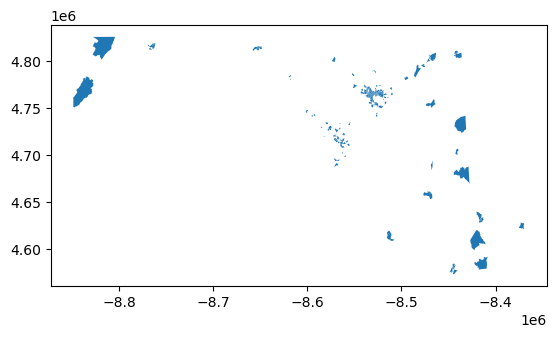

In [23]:
#Check new census tract datset accesible to plot. Risks_gdf2 is plotable 

risks_gdf2.plot()

In [ ]:
#Find a way to plot, or assign a geocode for gdf1 eviction dataset. GDF1 is plotable 

<Axes: >

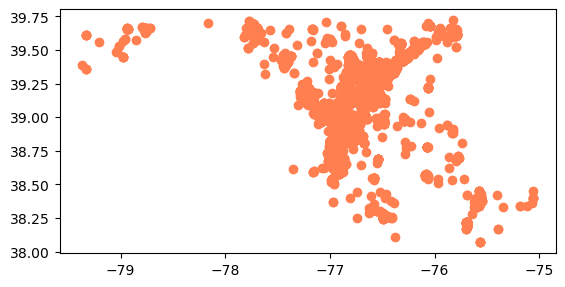

In [25]:
gdf1.plot(color='coral')


In [26]:
#Merge both gdf1 eviction dataset and risks_gdf2 high risk census dataset gdfs
#Requires installing package matplotlib 

import matplotlib.pyplot as plt

In [27]:
#Make sure both gdfs have same CRS

if gdf1.crs != risks_gdf2.crs:
    risks_gdf2 = risks_gdf2.to_crs(gdf1.crs)

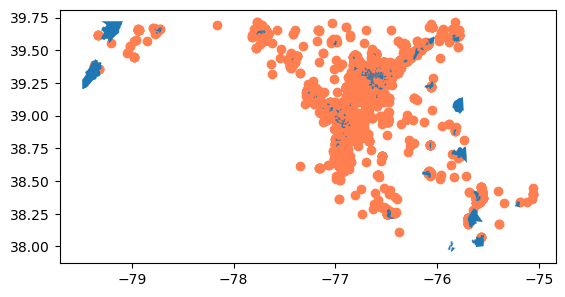

In [28]:
#Overlap plots and present 

fig, ax = plt.subplots()

# Plot gdf1 eviction first
gdf1.plot(ax=ax, color='coral')

# Overlay gdf2 high risk census tracts 
risks_gdf2.plot(ax=ax)


plt.show()